# How betweeness is correlated with energies of nodes?

In this experiment we are considering the measure of energy dispersion and its correlation to betweeness structural measure of nodes. There are multiple graph energies proposed in the literature, but our primary interest lies in Randić energy.

Within the experiment we calculate graph energy fo each node by means of their ego-network. Then we compare how betweenes of nodes is correlated with their ego-net graph enery.


### graph energy

Graph energy of a graph is defined as $E_G(G) = \sum\limits_{i=1}^n |\mu_i|$, where $\mu_1, \ldots, \mu_n$ are the eigenvalues of the adjacency matrix $M_A$ (also known as the *spectrum* of the graph).

### Randić energy

Randić matrix of the graph $G=\left<V, E\right>$ is defined as:

$$
M_R(i,j)=
\begin{cases}
0 & \mathit{if} & i=j\\
\frac{1}{\sqrt{d_i d_j}} & \mathit{if} & (i,j) \in E\\
0 & \mathit{if} & (i,j) \notin E
\end{cases}
$$

Randić energy of a graph is defined as $E_R(G) = \sum\limits_{i=1}^n |\rho_i|$, where $\rho_1, \ldots, \rho_n$ are the eigenvalues of the Randić matrix $M_R$.

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
from tqdm import tqdm
from ggplot import *

import pandas as pd
import numpy as np
import networkx as nx
import scipy, scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl

from sklearn import preprocessing, linear_model

from networkentropy import network_energy as ne
import time

from multiprocessing import Pool
import time
import itertools

import matplotlib.pyplot as plt
import networkx as nx

In [3]:
def chunks(l, n):
    """Divide a list of nodes `l` in `n` chunks"""
    l_c = iter(l)
    while 1:
        x = tuple(itertools.islice(l_c, n))
        if not x:
            return
        yield x


def _betmap(G_normalized_weight_sources_tuple):
    """Pool for multiprocess only accepts functions with one argument.
    This function uses a tuple as its only argument. We use a named tuple for
    python 3 compatibility, and then unpack it when we send it to
    `betweenness_centrality_source`
    """
    return nx.betweenness_centrality_source(*G_normalized_weight_sources_tuple)


def betweenness_centrality_parallel(G, processes=None):
    """Parallel betweenness centrality  function"""
    p = Pool(processes=processes)
    node_divisor = len(p._pool) * 4
    node_chunks = list(chunks(G.nodes(), int(G.order() / node_divisor)))
    num_chunks = len(node_chunks)
    bt_sc = p.map(_betmap,
                  zip([G] * num_chunks,
                      [True] * num_chunks,
                      [None] * num_chunks,
                      node_chunks))

    # Reduce the partial solutions
    bt_c = bt_sc[0]
    for bt in bt_sc[1:]:
        for n in bt:
            bt_c[n] += bt[n]
            
    p.close()
    return bt_c

def calculate_betweenes(graph, k):
    return nx.betweenness_centrality(graph, k=k)

def calculate_randic_energy(graph):
    results={}
    for n in graph.nodes:
        g = nx.ego_graph(G=graph, n=n, radius=1)
        results[n]=ne.get_randic_energy(g)
    return results

def calculate_graph_energy(graph):
    time_evaluation={}
    time_evaluation['ego']=0
    time_evaluation['graph_energy']=0
     
    results={}
    for n in graph.nodes:
        start = time.clock()
        g = nx.ego_graph(G=graph, n=n, radius=1)
        time_evaluation['ego']=time_evaluation['ego']+(time.clock() - start)
        start = time.clock()
        results[n]=ne.get_graph_energy(g)
        time_evaluation['graph_energy']=time_evaluation['graph_energy']+(time.clock() - start)
    return results, time_evaluation

def calculate_graph_energy_numpy(graph):
    results={}
    for n in graph.nodes:
        g = nx.ego_graph(G=graph, n=n, radius=1)
        results[n]=get_graph_energy_numpy(g)
    return results

def get_graph_energy_numpy(G):
    M = nx.adjacency_matrix(G).todense()
    graph_energy = np.abs(np.linalg.eigvals(M).real).sum()
    return graph_energy

def normalize_df_column(df_column):
    x = df_column.values.astype(float)
    min_max_scaler = skl.preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x.reshape(-1, 1))
    return x_scaled

### First experiment: synthetic data and graph energy and graph energy

wyliczenie dla wszystkich wierzchołków sieci ich pośrednictwa, pośrednictwa szacowanego na podstawie ścieżek o długości 2, 3, ..., k, oraz energii macierzy sąsiedztwa w sieci egocentrycznej

In [47]:
num_nodes=50

results = pd.DataFrame(columns=['node', 
                                'betweenness', 
                                'randic_energy', 
                                'graph_energy', 
                                'model', 
                                'model_param'])

# FIXTURE: computing for all possible values in the range [1,100] takes too long and it is difficult
# to visualize the results, each network should be examined on its own because small changes in the 
# network generation parameter can drastically change the topology of the network

model_params = [10, 20, 30, 40, 50]

for p in model_params:

    generators = {
        'random': nx.erdos_renyi_graph(n=num_nodes, p=p/100.0),
        'smallworld': nx.watts_strogatz_graph(n=num_nodes, k=4, p=p/100.0),
        'waxman': nx.waxman_graph(n=num_nodes, alpha=p/100.0, beta=0.1),
        'powerlaw': nx.powerlaw_cluster_graph(n=num_nodes, m=3, p=p/1000.0)
    }
    
    for generator in generators.keys():
        
        G = generators[generator]

# TODO: do it later, for the moment we'll measure the correlation between 
# exact betweenness and vertex energies
#
#         bet={}
#         for k in range(2,num_nodes,int(num_nodes/betweenness_parameter_samples)):
#             bb=calculate_betweenes(G,k=k)
            
#             tmp_df=pd.DataFrame({'node': [i[0] for i in bb.items()],
#                                  'value_type': ['betweenness' for i in bb.items()],
#                                  'value_param': [k for i in bb.items()],
#                                  'value': [i[1] for i in bb.items()],
#                                  'network': [generator for i in bb.items()],
#                                  'network_param': [p for i in bb.items()]
#                                 })
#             tmp_df['value']=normalize_df_column(tmp_df['value'])
#             results=pd.concat([results,tmp_df])
        
        be = calculate_betweenes(G, k=None)
        re = calculate_randic_energy(G)
        ge,_ = calculate_graph_energy(G)
        
        _dict = {
            'node': list(G.nodes),
            'betweenness': list(be.values()),
            'randic_energy': list(re.values()),
            'graph_energy': list(ge.values()),
            'model': [generator] * G.number_of_nodes(),
            'model_param': [p] * G.number_of_nodes()
        }
        
        _result = pd.DataFrame.from_dict(_dict)
        
        results = pd.concat([results, _result], axis=0)

As the next step we fit a simple linear model and compute its accuracy in terms of

  * Pearson, Spearman, and Kendall correlations
  * mean absolute error
  * mean squarred error

In [176]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr, spearmanr, kendalltau, rankdata

reg = LinearRegression()

prediction_results = []

for model in results['model'].unique():
    for model_param in model_params:
        
        model_idx = results['model'] == model
        param_idx = results['model_param'] == model_param
        
        df = results[ model_idx & param_idx]
        
        y = df['betweenness'].values
        X = df['graph_energy'].values
        
        reg.fit(X=X.reshape(-1, 1), y=y)
        y_pred = reg.predict(X.reshape(-1, 1))
        
        y_ranked = rankdata(y, method='ordinal') 
        y_pred_ranked = rankdata(y_pred, method='ordinal')
        
        _dict = {
            'model': model,
            'model_param': model_param,
            'mae': mean_absolute_error(y_true=y, y_pred=y_pred),
            'mse': mean_squared_error(y_true=y, y_pred=y_pred),
            'r2': r2_score(y, y_pred),
            'pearson': pearsonr(y, y_pred)[0],
            'spearman': spearmanr(y, y_pred, axis=0, nan_policy='propagate')[0],
            'kendall': kendalltau(y_ranked, y_pred_ranked, initial_lexsort=None, nan_policy='propagate')[0]
        }
        
        prediction_results.append(_dict)

# convert the list of dicts into a DataFrame
prediction_results = pd.DataFrame(prediction_results, 
             columns=['model', 'model_param', 'mae', 'mse', 'r2', 'pearson', 'spearman', 'kendall'])

# melt DataFrame to transform it into tidy format
prediction_results = pd.melt(prediction_results,
                             id_vars=['model','model_param'], 
                             var_name='error_type',
                             value_name='error_value')
prediction_results

,model,model_param,error_type,error_value
0,random,10,mae,0.018955
1,random,20,mae,0.005058
2,random,30,mae,0.002356
3,random,40,mae,0.001476
4,random,50,mae,0.000876
5,smallworld,10,mae,0.038653
6,smallworld,20,mae,0.029597
7,smallworld,30,mae,0.024226
8,smallworld,40,mae,0.022056
9,smallworld,50,mae,0.018137


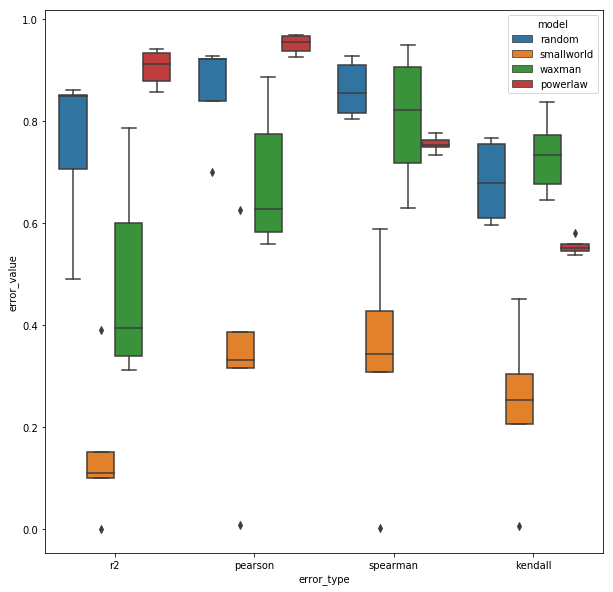

In [208]:
df = prediction_results[prediction_results['error_type'].isin(['r2', 'pearson', 'spearman', 'kendall'])]

fig, ax = plt.subplots(figsize=(10.0, 10.0))
sns.boxplot(data = df, ax = ax, x = 'error_type', y = 'error_value', hue = 'model')

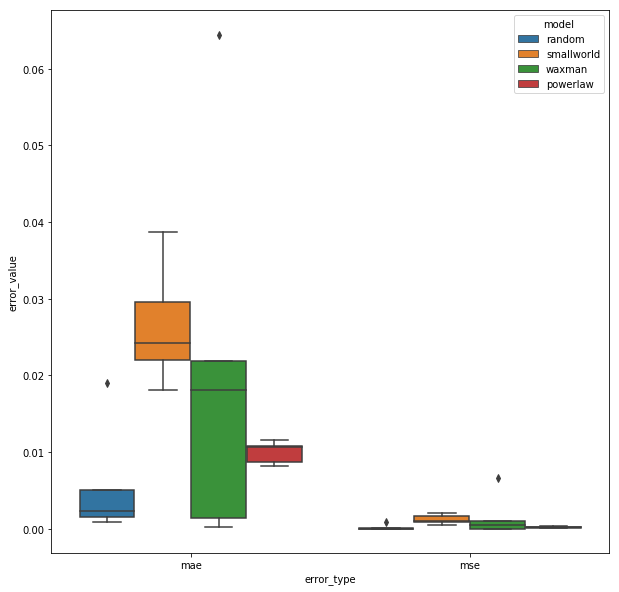

In [211]:
df = prediction_results[prediction_results['error_type'].isin(['mae', 'mse'])]

fig, ax = plt.subplots(figsize=(10.0, 10.0))
sns.boxplot(data = df, ax = ax, x = 'error_type', y = 'error_value', hue = 'model')

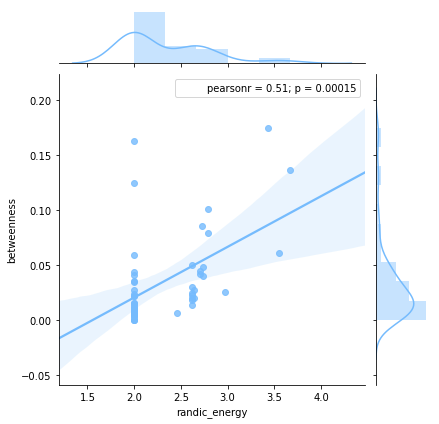

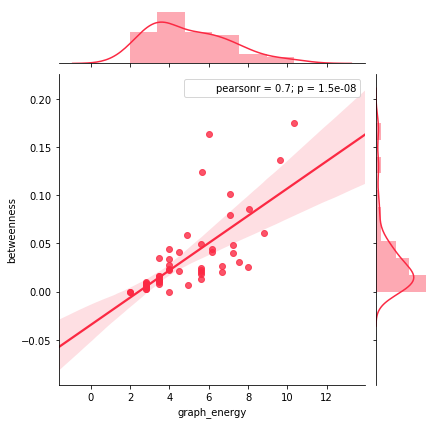

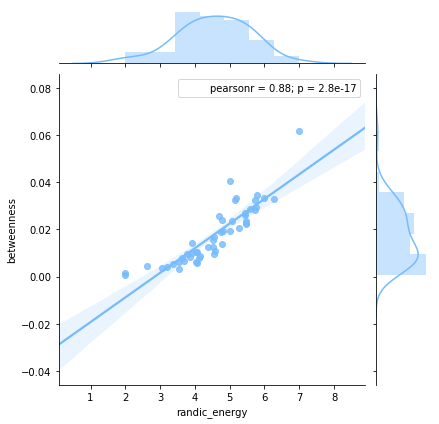

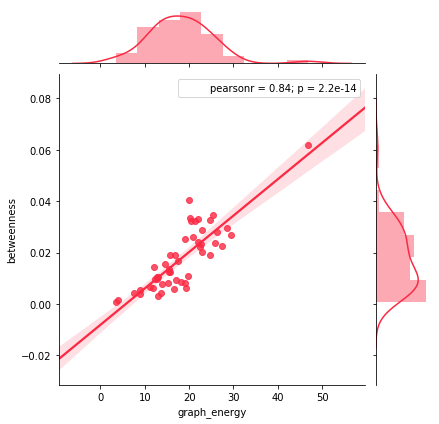

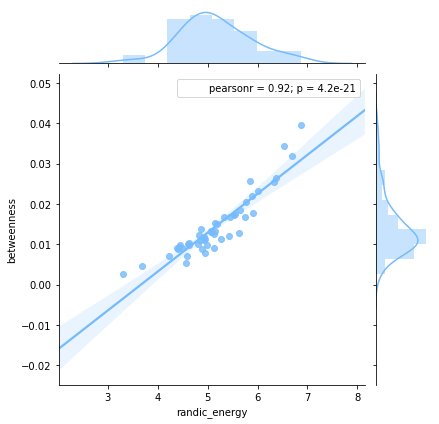

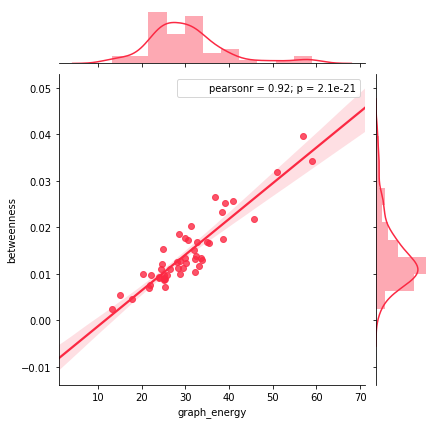

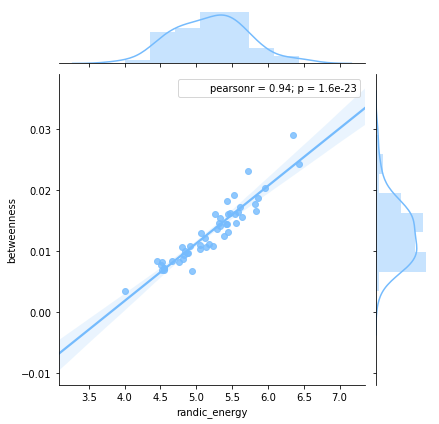

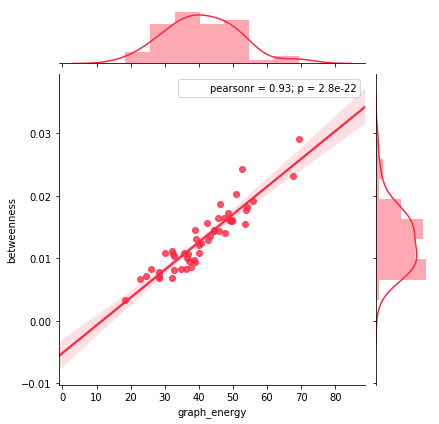

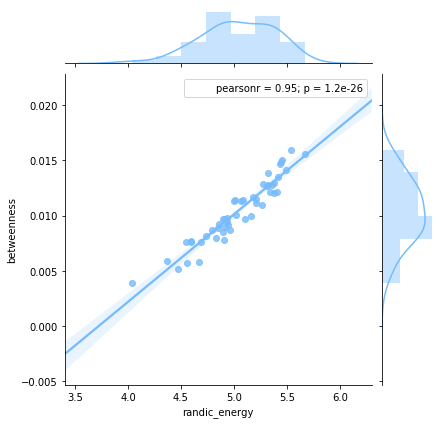

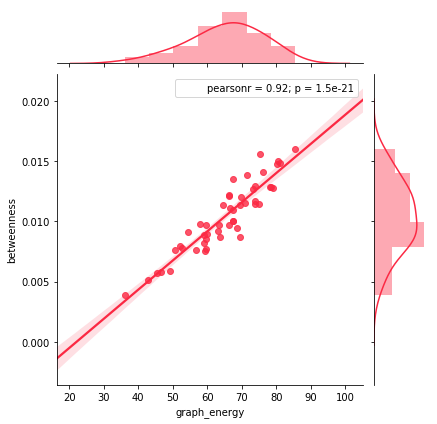

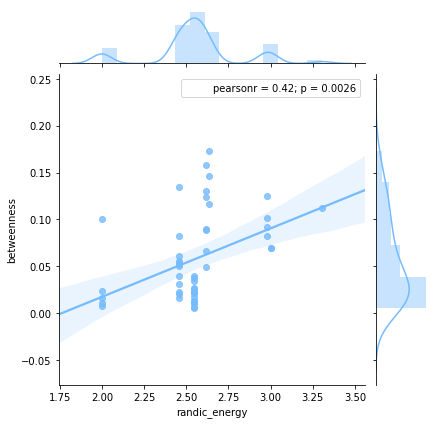

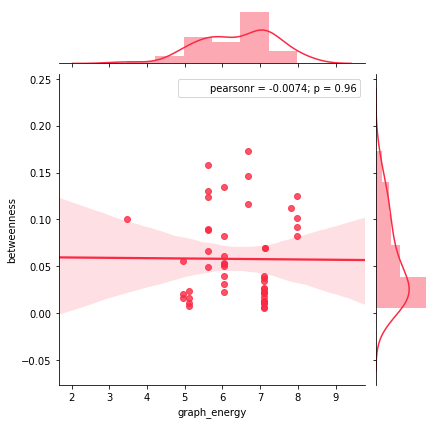

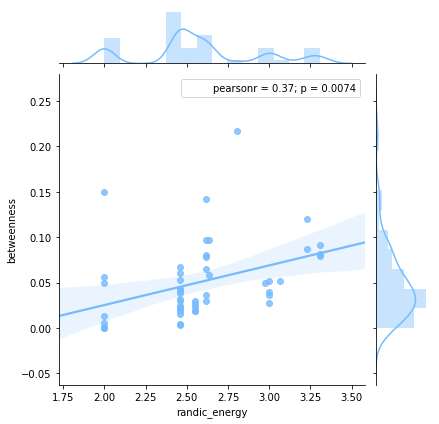

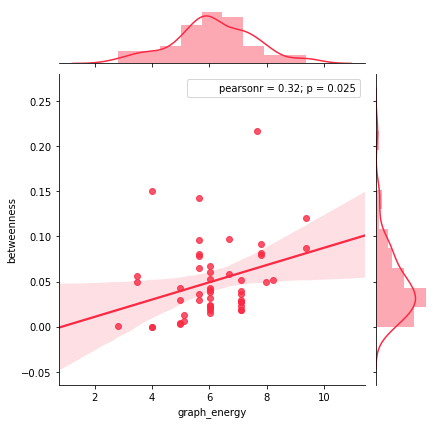

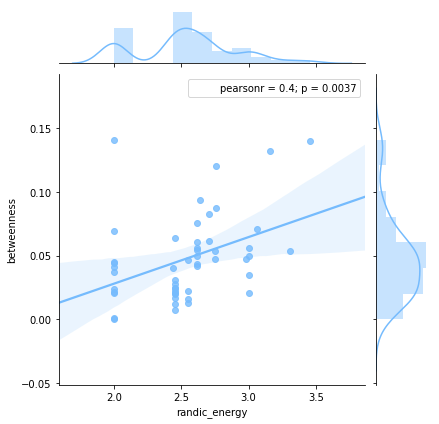

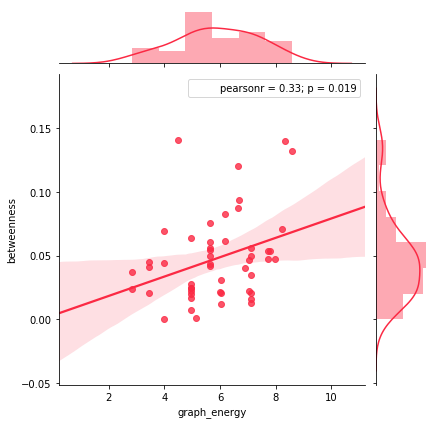

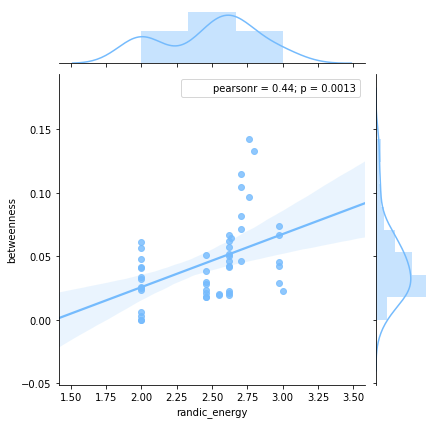

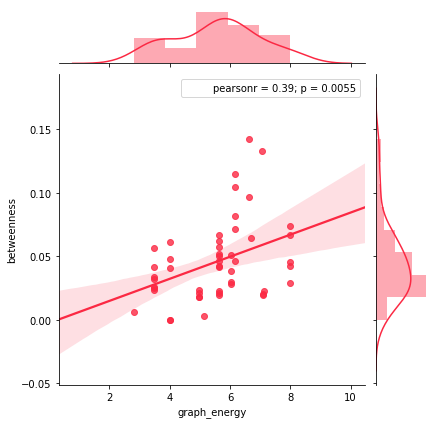

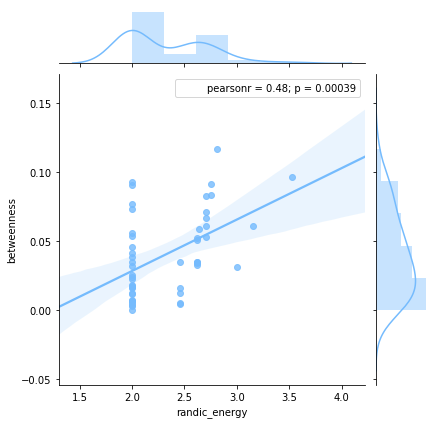

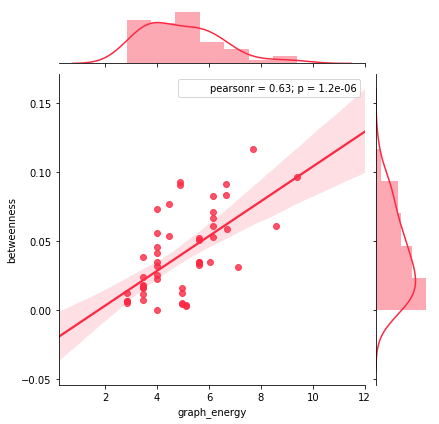

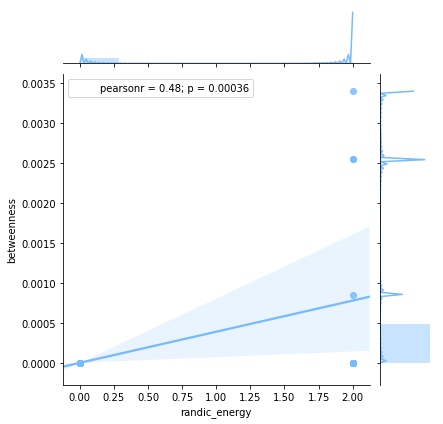

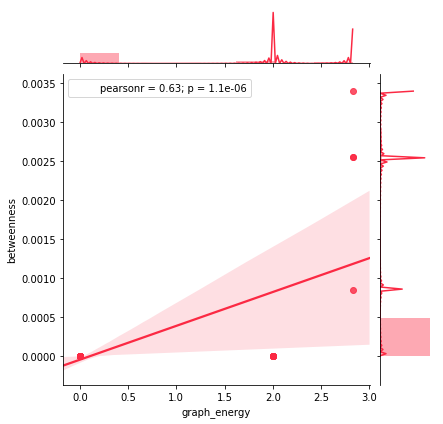

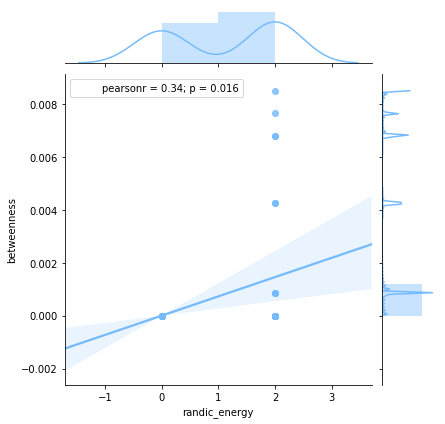

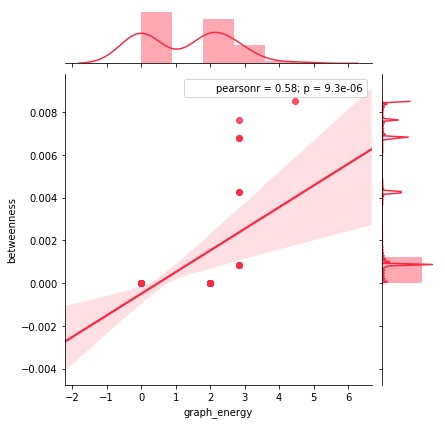

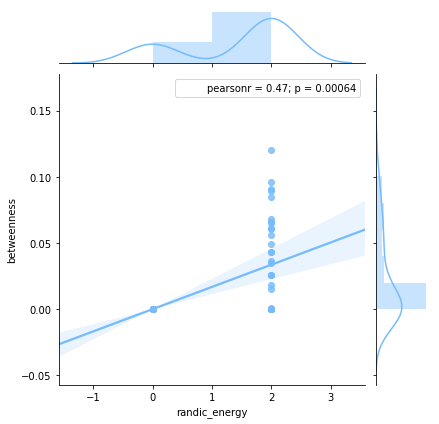

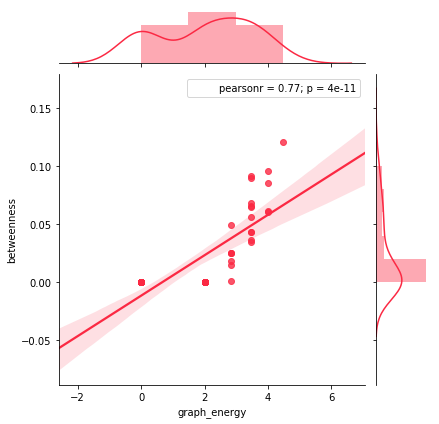

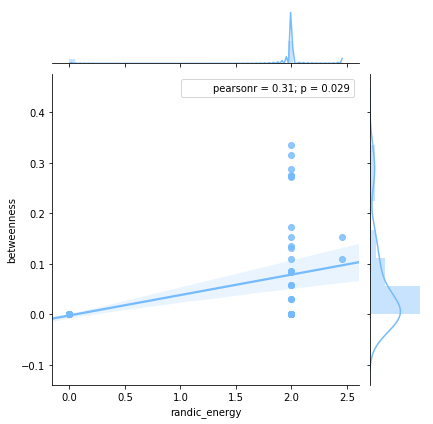

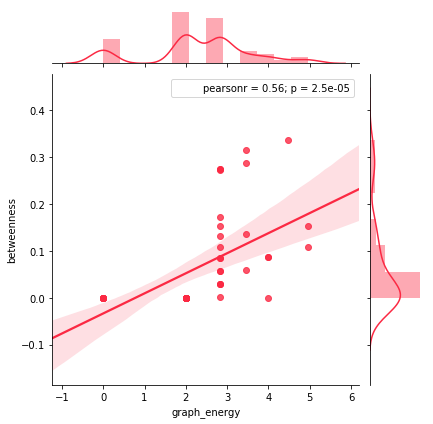

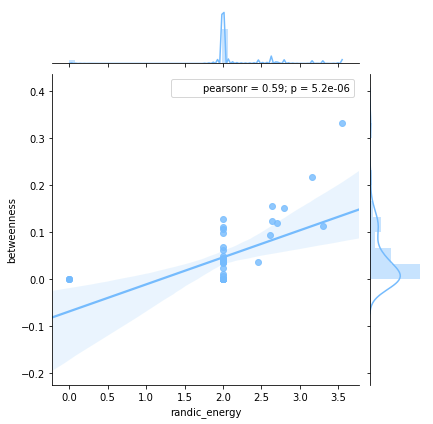

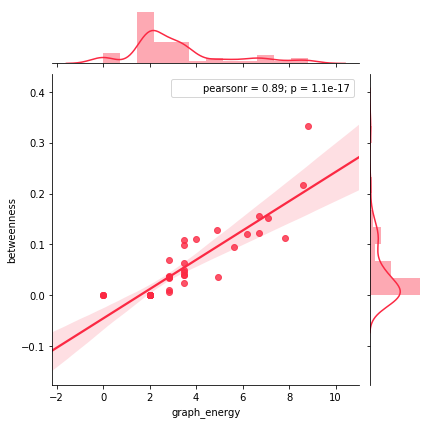

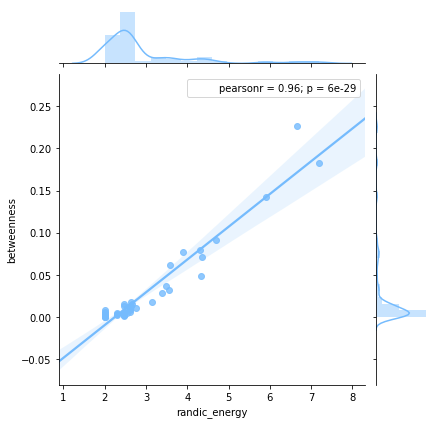

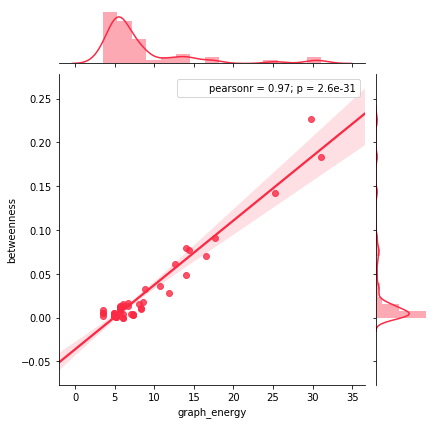

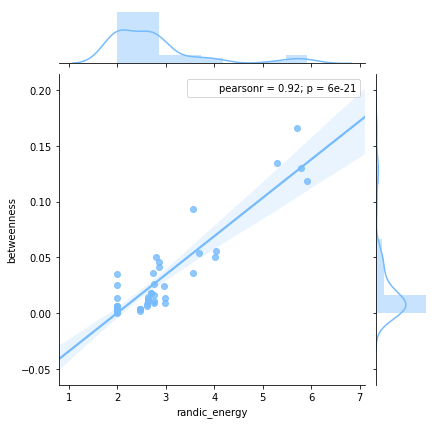

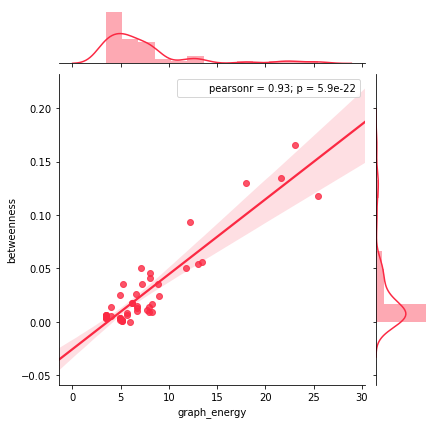

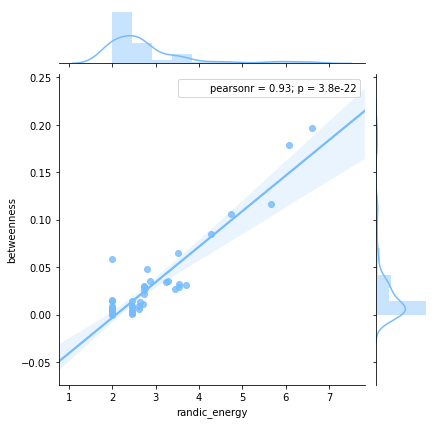

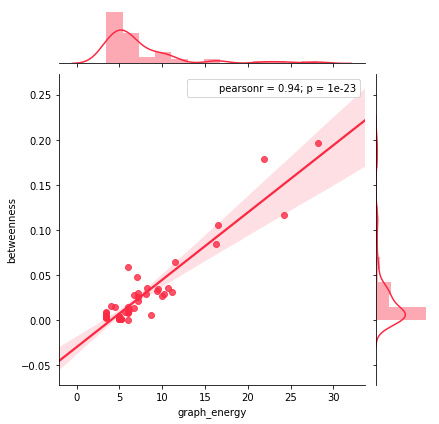

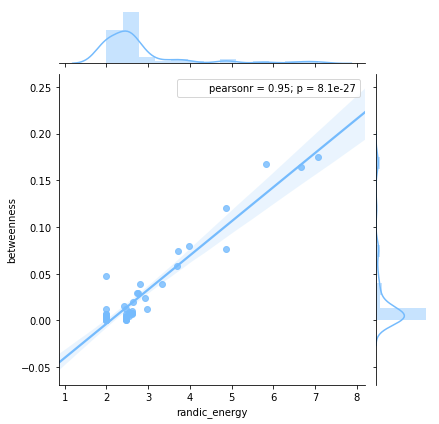

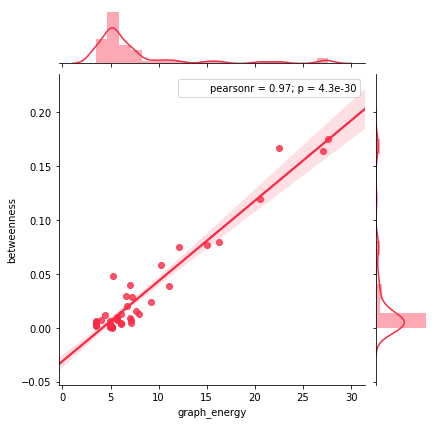

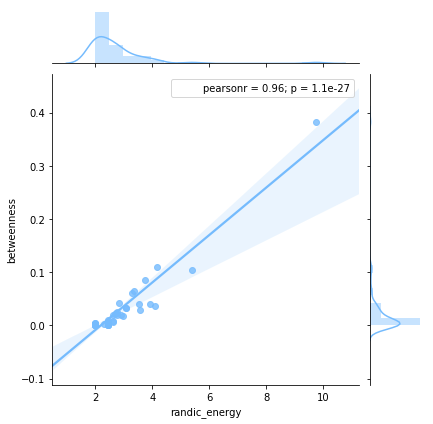

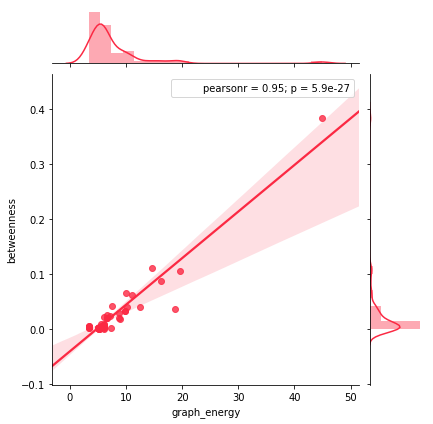

In [214]:
# TODO: don't know how to add titles to jointplots

for model in results.model.unique():    
    for param in model_params:

        
        sns.jointplot(x='randic_energy', 
                      y='betweenness', 
                      data=results[(results['model'] == model) & (results['model_param'] == param)], 
                      kind='reg', 
                      color="xkcd:sky blue")

        sns.jointplot(x='graph_energy', 
                      y='betweenness',
                      data=results[(results['model'] == model) & (results['model_param'] == param)], 
                      kind="reg", 
                      color="xkcd:strawberry")

In order to present the degree of relationship between considered variables first we need to normalize the values. Since networks have been generated for different values of the generation parameter, for the sake of brevity we fix this value to p=50.

In [151]:
from sklearn import preprocessing

network_generation_parameter = 50 # can be any value between 1 and 100

min_max_scaler = preprocessing.MinMaxScaler()

df = results[['betweenness','randic_energy','graph_energy','model']][results['model_param'] == network_generation_parameter]

df_scaled = min_max_scaler.fit_transform(df[['betweenness','randic_energy','graph_energy']])
df_normalized = pd.DataFrame(df_scaled, columns=['betweenness','randic_energy','graph_energy'])
df_normalized['model'] = df['model'].values

Below we present correlation measures (Pearson, Spearman, Kendall) which describe the relationship of betweenness and vertex energies (Randic and graph)

In [152]:
result = []

for model in df_normalized.model.unique():
    for method in ['kendall','spearman','pearson']:
        _corr = df_normalized[df_normalized['model'] == model][['betweenness','randic_energy','graph_energy']].corr(method=method)
        result.append((model, method, _corr.betweenness['randic_energy'], _corr.betweenness['graph_energy']))
        
correlations = pd.DataFrame(result, 
                            columns=['model', 'method', 'betweenness_randic_corr', 'betweenness_graph_corr'])

print(correlations)

         model    method  betweenness_randic_corr  betweenness_graph_corr
0       random   kendall                 0.841633                0.755102
1       random  spearman                 0.964370                0.910396
2       random   pearson                 0.953546                0.922959
3   smallworld   kendall                 0.310276                0.460261
4   smallworld  spearman                 0.387891                0.589201
5   smallworld   pearson                 0.482443                0.625367
6       waxman   kendall                 0.483914                0.863202
7       waxman  spearman                 0.577088                0.948962
8       waxman   pearson                 0.594845                0.886625
9     powerlaw   kendall                 0.696466                0.586220
10    powerlaw  spearman                 0.853335                0.776935
11    powerlaw   pearson                 0.957995                0.954876


Plot below shows the fitted linear relationship between vertex betweenness and vertex Randic energy for four considered artificial network models (generation parameter p=50)

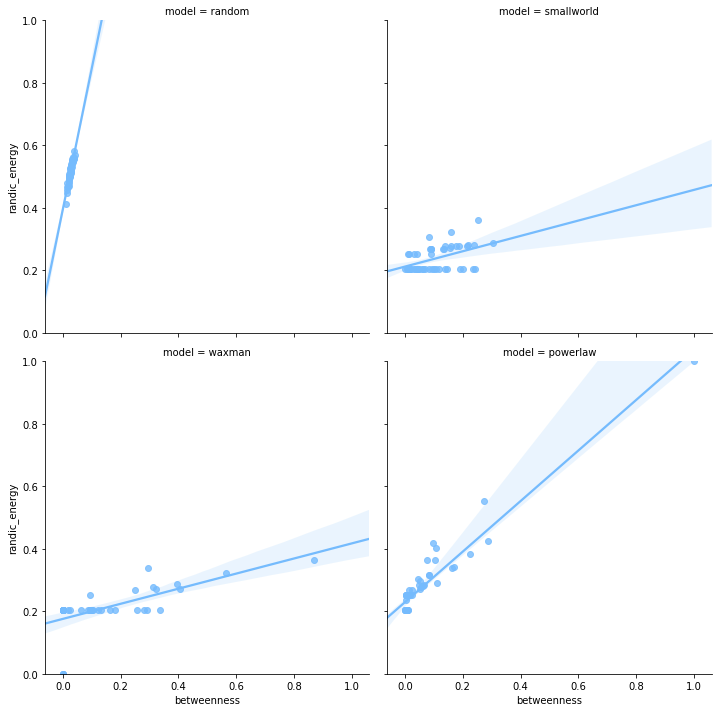

In [148]:
# TODO: would be nice to have jointplots instead of lmplots, but jointplot calls JointGrid which produces 
# a new figure on every call and I don't know how to put these into a single grid

g = sns.lmplot(data = df_normalized, 
               x = 'betweenness', 
               y = 'randic_energy', 
               col = 'model',
               col_wrap = 2,
               line_kws = {'color': 'xkcd:sky blue'},
               scatter_kws = {'color': 'xkcd:sky blue'})

g.set(ylim=(0,1))

Plot below shows the fitted linear relationship between vertex betweenness and vertex graph energy for four considered artificial network models (generation parameter p=50)

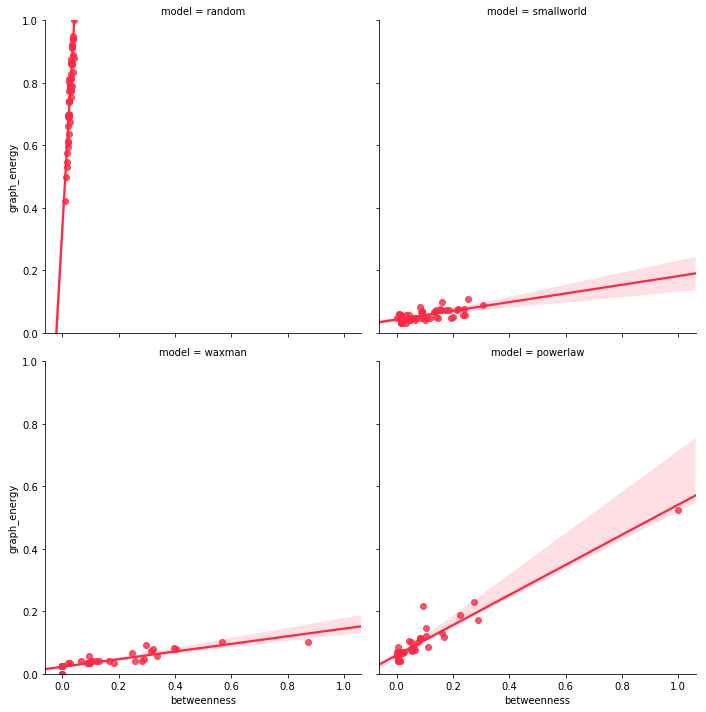

In [125]:
g = sns.lmplot(data = df_normalized, 
               x = 'betweenness', 
               y = 'graph_energy', 
               col = 'model',
               col_wrap = 2,
               line_kws = {'color': 'xkcd:strawberry'},
               scatter_kws = {'color': 'xkcd:strawberry'})

g.set(ylim=(0,1))

### Second experiment: real-word data

In [131]:
from bs4 import BeautifulSoup
import requests
import wget
import tarfile
import os
import shutil
import time

In [132]:
def read_avalilable_datasets_konect():
    base_url = "http://konect.uni-koblenz.de/downloads/"
#     print(base_url)
    response = requests.get(base_url)
    
    if response.status_code != 200:
        print("An error occurred while getting data.")
    else:
        html = response.content
        soup = BeautifulSoup(html, "html5lib")
        
        table_html = soup.find(id='sort1')
        
        thead_html = table_html.find('thead')
        tbody_html = table_html.find('tbody')
         
        column_names=[row.text for row in thead_html.findAll('td')]
        rows = tbody_html.findAll('tr')
        values=[[cell.get('href') for cell in value('a') if 'tsv' in cell.get('href')] for value in rows]
        return [val[0].replace('.tar.bz2','').replace('tsv/','') for val in values]
        
def download_tsv_dataset_konect(network_name):
    assert (network_name in read_avalilable_datasets_konect()),"No network named: '"+network_name+"' found in Konect!"
    
    tsv_file = 'http://konect.uni-koblenz.de/downloads/tsv/'+network_name+'.tar.bz2'
    output_file=network_name+'.tar.bz2'
    file_name = wget.download(tsv_file, out=output_file)
    if os.path.exists(output_file):
        shutil.move(file_name,output_file)
    
    return output_file
    
def unpack_tar_bz2_file(file_name):
    tar = tarfile.open("./"+file_name, "r:bz2")
    output_dir="./network_"+file_name.replace('.tar.bz2','')+"/"
    tar.extractall(output_dir)
    tar.close()
    return output_dir

def build_network_from_out_konect(network_name):
    file_name=download_tsv_dataset_konect(network_name=network_name)
    output_dir=unpack_tar_bz2_file(file_name)+network_name+"/"
    files = [file for file in os.listdir(output_dir) if os.path.isfile(os.path.join(output_dir, file))]
    out_file = [file for file in files if 'out.' in file]
    assert (len(out_file)>0), 'No out. file in the directory.'
    
    #building network
    G=nx.read_adjlist(output_dir+out_file[0], comments='%')
    
    return G

In [133]:
networks_names=['moreno_beach',
 'moreno_bison',
 'moreno_blogs',
 'moreno_cattle',
 'moreno_crime',
 'moreno_health',
#  'moreno_hens',
 'moreno_highschool',
 'moreno_innovation',
 'moreno_kangaroo',
 'moreno_lesmis',
 'moreno_mac',
 'moreno_names',
 'moreno_oz',
 'moreno_propro',
 'moreno_rhesus',
 'moreno_sampson',
 'moreno_seventh',
 'moreno_sheep',
 'moreno_taro',
 'moreno_train',
 'moreno_vdb',
 'moreno_zebra',
#  'brunson_club-membership',
#  'brunson_southern-women',
#  'brunson_corporate-leadership',
#  'brunson_revolution',
#  'brunson_south-africa',
#  'ucidata-gama',
#  'ucidata-zachary',
#  'opsahl-collaboration',
#  'opsahl-openflights',
#  'opsahl-powergrid',
#  'opsahl-southernwomen',
#  'opsahl-ucforum',
#  'opsahl-ucsocial',
#  'opsahl-usairport',
#  'contiguous-usa',
#  'dolphins',
#  'adjnoun_adjacency',
#  'mit',
#  'foodweb-baydry',
#  'foodweb-baywet',
#  'sociopatterns-hypertext',
#  'sociopatterns-infectious',
#  'radoslaw_email'
               ]

In [134]:
networks=[]
for network_name in tqdm(networks_names):
    networks.append(build_network_from_out_konect(network_name))

100%|██████████| 22/22 [00:15<00:00,  1.40it/s]


### Third experiment - checking the linear approximation of betweenness with entropies in real world networks

Firstly we calculate betweenness and energy measures for each node.

In [135]:
real_data_measures=pd.DataFrame(columns=['node', 'value_type','value','network'])

for i in tqdm(range(len(networks))):
    G = networks[i]
    
    be=calculate_betweenes(G,k=None)
    tmp_df=pd.DataFrame({'node': [i[0] for i in be.items()],
                         'value_type': ['betweenness' for i in be.items()],
                         'value': [i[1] for i in be.items()],
                         'network': [networks_names[i] for j in be.items()]
                        })
    tmp_df['value']=normalize_df_column(tmp_df['value'])
    real_data_measures=pd.concat([real_data_measures,tmp_df])
        
        
    re=calculate_randic_energy(G)
    tmp_df=pd.DataFrame({'node': [i[0] for i in re.items()],
                         'value_type': ['randic' for i in re.items()],
                         'value': [i[1] for i in re.items()],
                         'network': [networks_names[i] for j in be.items()]
                        })
    tmp_df['value']=normalize_df_column(tmp_df['value'])
    real_data_measures=pd.concat([real_data_measures,tmp_df])

    ge,_=calculate_graph_energy(G)
    tmp_df=pd.DataFrame({'node': [i[0] for i in ge.items()],
                         'value_type': ['graph' for i in ge.items()],
                         'value': [i[1] for i in ge.items()],
                         'network': [networks_names[i] for j in be.items()]
                        })
    tmp_df['value']=normalize_df_column(tmp_df['value'])
    real_data_measures=pd.concat([real_data_measures,tmp_df])

100%|██████████| 22/22 [04:11<00:00, 11.41s/it]


In [ ]:
real_data_measures.to_pickle('./real_networks_calulated_betweenness_and_energy.pickle')

In [ ]:
def evaluate_results(net, y, y_pred):
    real_prediction_results=pd.DataFrame(columns=['network', 'error_type', 'error_value'])
    
    mae=skl.metrics.mean_absolute_error(y_true=y, y_pred=y_pred)
    tmp_df=pd.DataFrame({'network': [net],
                         'error_type': ['MAE'], 
                         'error_value': [mae]
                        })
    real_prediction_results=pd.concat([real_prediction_results,tmp_df])

    mse=skl.metrics.mean_squared_error(y_true=y, y_pred=y_pred)
    tmp_df=pd.DataFrame({'network': [net],
                         'error_type': ['MSE'], 
                         'error_value': [mse]
                        })
    real_prediction_results=pd.concat([real_prediction_results,tmp_df])

    pearson,_=scipy.stats.pearsonr(x=y,y=y_pred)
    tmp_df=pd.DataFrame({'network': [net],
                         'error_type': ['pearson'], 
                         'error_value': [pearson]
                        })
    real_prediction_results=pd.concat([real_prediction_results,tmp_df])

    spearman,_=scipy.stats.spearmanr(a=y,b=y_pred, axis=0, nan_policy='propagate')
    tmp_df=pd.DataFrame({'network': [net],
                         'error_type': ['spearman'], 
                         'error_value': [spearman]
                        })
    real_prediction_results=pd.concat([real_prediction_results,tmp_df])


    y_ranked=scipy.stats.rankdata(y, method='ordinal') #może metoda average
    y_pred_ranked=scipy.stats.rankdata(y_pred, method='ordinal')

    kendall,_=scipy.stats.kendalltau(x=y_ranked,y=y_pred_ranked, initial_lexsort=None, nan_policy='propagate')
    tmp_df=pd.DataFrame({'network': [net],
                         'error_type': ['kendall'], 
                         'error_value': [kendall]
                        })
    real_prediction_results=pd.concat([real_prediction_results,tmp_df])    
    
    return real_prediction_results

In [ ]:
from sklearn import linear_model
from sklearn.svm import SVR

l_model=linear_model.LinearRegression()
real_prediction_results=pd.DataFrame(columns=['network', 'error_type', 'error_value'])
models = []
real_data_measures=pd.read_pickle('./real_networks_calulated_betweenness_and_energy.pickle')


for net in tqdm(real_data_measures['network'].unique()):
        print(net)
        l_model=linear_model.LinearRegression()
#        l_model= SVR(kernel='rbf', C=1e3, gamma=0.1)
#        l_model=linear_model.LogisticRegression()
        y=real_data_measures[(real_data_measures['network']==net) & 
                  (real_data_measures['value_type']=='betweenness')
                 ]['value'].values

        X=real_data_measures[(real_data_measures['network']==net) & 
                  (real_data_measures['value_type']=='graph')
                 ]['value'].values

        l_model.fit(X=X.reshape(-1, 1), y=y)

        models.append(l_model)
        
        y_pred=l_model.predict(X.reshape(-1, 1))
        
        real_prediction_results=pd.concat([real_prediction_results,evaluate_results(net,y,y_pred)])
        
        
real_prediction_results.to_pickle('./real_prediction_results_errors.pickle')     

In [ ]:
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)

In [ ]:
real_prediction_results=pd.read_pickle('./real_prediction_results_errors.pickle') 

f, axs = plt.subplots(5, 1, figsize=(10, 28), sharex=True)

for error_type,ax in zip(real_prediction_results['error_type'].unique(),axs):
    x=real_prediction_results[real_prediction_results['error_type']==error_type]['network'].values
    y=real_prediction_results[real_prediction_results['error_type']==error_type]['error_value'].values
    
#     plt.title(error_type)
#     plt.xticks(rotation='vertical')
    plt.ylim([0,1])
#     plt.scatter(x=x, y=y)
#     plt.show()
    
#     plt.setp(f.axes, title=error_type)
    
    ax.set_xticklabels(x,rotation='vertical')
    ax.set_title(error_type, fontsize=18)
    ax.set(xlabel='Network', ylabel='Value')
    sns.barplot(x, y, palette="BuGn_d", ax=ax)
    
sns.despine(bottom=True)
plt.tight_layout(h_pad=3)


### Fourth experiment: Transfer learning

In [ ]:


real_data_measures=pd.read_pickle('./real_networks_calulated_betweenness_and_energy.pickle')

transfer_real_prediction_results=pd.DataFrame(columns=['network', 'error_type', 'error_value', 'source_network'])

raw_results=pd.DataFrame(columns=['network', 'source_network', 'y', 'y_pred'])


for i in tqdm(range(len(models))):
    for net in (real_data_measures['network'].unique()):
        y=real_data_measures[(real_data_measures['network']==net) & 
                  (real_data_measures['value_type']=='betweenness')
                 ]['value'].values

        X=real_data_measures[(real_data_measures['network']==net) & 
                  (real_data_measures['value_type']=='graph')
                 ]['value'].values
        
        y_pred=models[i].predict(X.reshape(-1, 1))
        
        eval_res=evaluate_results(net,y,y_pred)
        eval_res['source_network']=networks_names[i]
        
        raw_results=pd.concat([raw_results, pd.DataFrame.from_dict({'network': net, 'source_network': networks_names[i], 'y': y, 'y_pred':y_pred})])
        
        transfer_real_prediction_results=pd.concat([transfer_real_prediction_results,eval_res])

lets draw heatmap

In [ ]:
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.8)

for error_type in transfer_real_prediction_results['error_type'].unique():
    x=transfer_real_prediction_results[transfer_real_prediction_results['error_type']==error_type]['network'].unique()
    y=transfer_real_prediction_results[transfer_real_prediction_results['error_type']==error_type]['network'].unique()
    val=transfer_real_prediction_results[transfer_real_prediction_results['error_type']==error_type]['error_value']
#     print(val)
    val=np.array(val)
    val=val.reshape(len(x),len(y))
#     print(val)
    
#     plt.title(error_type)
#     plt.xticks(rotation='vertical')
#     plt.ylabel(y)
#     plt.imshow(val, cmap='hot', interpolation='nearest')
    

    plt.figure(figsize=(10,10))
    plt.title(error_type)
    
    to_draw=transfer_real_prediction_results[transfer_real_prediction_results['error_type']==error_type]
#     print(to_draw)
    ax = sns.heatmap(to_draw[['error_value', 'source_network', 'network']].pivot('source_network','network','error_value'), linewidth=0.5)
    ax.invert_yaxis()
    plt.show()
    

#### Summary: 
- all (obviously with some variance) networks have high correlations between Randić energy of ego networks and betweeness

### Available datasets from KONECT

In [ ]:
read_avalilable_datasets_konect()


# Plan eksperymentu (PL)
- wyliczenie dla wszystkich wierzchołków sieci ich pośrednictwa, pośrednictwa szacowanego na podstawie ścieżek o długości 2, 3, ..., k, oraz energii macierzy sąsiedztwa w sieci egocentrycznej
- wyznaczenie prostej regresji liniowej m/y pośrednictwem i energią wierzchołka, miarami jakości mogą być:
  * korelacja Pearsona
  * korelacja Spearmana
  * korelacja Kendalla
  * błąd bezwzględny (po normalizacji obu miar)
  * błąd średniokwadratowy (po normalizacji obu miar)
- do porównania bierzemy wynik na podstawie energii i porównujemy z wynikiem na podstawie estymacji pośrednictwa
- zamiast prostej regresji możemy nauczyć model, korzystając z następujących cech:
  * energia macierzy sąsiedztwa sieci egocentrycznej wierzchołka
  * min/avg/max energii macierzy sąsiedztwa sąsiadów wierzchołka

- jako dodatkowy bonus możemy pokazać, że w przypadku energii następuje transfer learning, tzn. możemy nauczyć model raz na jednej instancji sieci i wyznaczyć jego dokładność dla całego zbioru sieci po podobnej topologii, ale nieco innych parametrach (zakładając, że wierzchołki nie mają tożsamości, nie da się takiego transferu przeprowadzić innymi metodami)